# Lab3. Pytorch Classification (Logistic Regression vs MLP)  
*   Classification Problem을 `pytorch`로 해결
*   두가지 모델(Linear Regression, MLP)을 둘 다 구현
*   모델이 생각하는 데이터 분포를 시각화해서 MLP가 실제로 non-linear Decision-Boundary를 가질 수 있는지 살펴보자


### Install Pytorch 1.0 (For Google Colab)

In [1]:
#구글 Colab에서 실행할 때는 이 주석을 해제하시고 실행해서 pytorch 1.0을 깔아주세요!
!pip install -q torch==1.0.0 torchvision
import torch
print(torch.__version__)


     |████████████████████████████████| 591.8 MB 589 bytes/s 
     |████████████████████████████████| 23.3 MB 79.9 MB/s 
     |████████████████████████████████| 23.3 MB 1.3 MB/s 
     |████████████████████████████████| 22.1 MB 1.4 MB/s 
     |████████████████████████████████| 22.1 MB 1.3 MB/s 
     |████████████████████████████████| 17.4 MB 109 kB/s 
     |████████████████████████████████| 17.3 MB 121 kB/s 
     |████████████████████████████████| 12.8 MB 40.6 MB/s 
     |████████████████████████████████| 12.7 MB 47.4 MB/s 
     |████████████████████████████████| 11.8 MB 30.1 MB/s 
     |████████████████████████████████| 5.9 MB 42.4 MB/s 
     |████████████████████████████████| 6.6 MB 23.9 MB/s 
     |████████████████████████████████| 6.6 MB 53.5 MB/s 
     |████████████████████████████████| 4.0 MB 36.4 MB/s 
     |████████████████████████████████| 10.2 MB 35.6 MB/s 
     |████████████████████████████████| 10.1 MB 19.5 MB/s 
     |████████████████████████████████| 8.8 MB 1.1 MB/s 
     

### 1. Data Generation  (Preparation)


*   Classification 실습에 사용할 데이터를 만들기

*   X= 2차원, X는 모두 continuous space에 존재
*   Y= 1차원, Y는 class이기 때문에 discrete space에 분포


*   방사형 데이터 분포를 가상으로 만든 후에 두 모델들이 비선형 decision-boundary를 형성할 수 있는지 테스트



**Data Set**  
$$X_{train} \in \mathcal{R}^{8000 \times 2}, Y_{train} \in \mathcal{Z}^{8000}$$  
$$X_{val} \in \mathcal{R}^{1000 \times 2}, Y_{val} \in \mathcal{Z}^{1000}$$  
$$X_{test} \in \mathcal{R}^{1000 \times 2}, Y_{test} \in \mathcal{Z}^{1000}$$

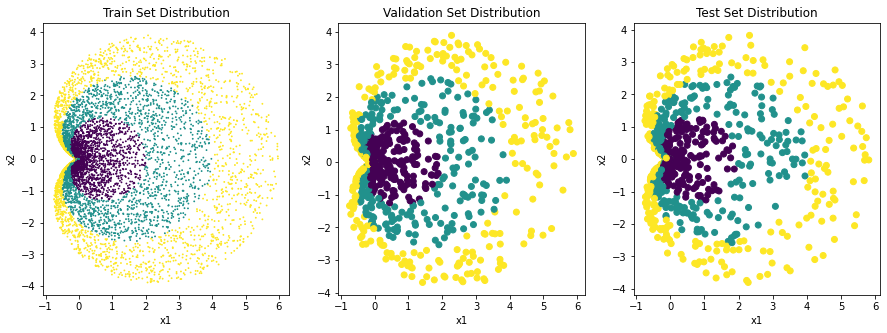

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

#데이터셋 만들기 
r = np.random.rand(10000)*3  #r=10000개
theta = np.random.rand(10000)*2*np.pi  #세타역시=10000개  
y = r.astype(int)  #y를 다 정수형으로 변형(소수점제거),클래스가 정수형(0,1,2)로 나뉘기 위함
r = r * (np.cos(theta) + 1)
x1 = r * np.cos(theta)
x2 = r * np.sin(theta)
X = np.array([x1, x2]).T

#데이터셋을 Train, Validation, Test으로 split
train_X, train_y = X[:8000, :], y[:8000]  #8000개
val_X, val_y = X[8000:9000, :], y[8000:9000]  #1000개
test_X, test_y = X[9000:, :], y[9000:]  #1000개

#Visualize
fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(1, 3, 1)
ax1.scatter(train_X[:, 0], train_X[:, 1], c=train_y, s=0.7)  #c=train_y, 각 클래스별로 다른색을 가지도록,s는 점의사이즈
ax1.set_xlabel('x1')
ax1.set_ylabel('x2')
ax1.set_title('Train Set Distribution')

ax2 = fig.add_subplot(1, 3, 2)
ax2.scatter(val_X[:, 0], val_X[:, 1], c=val_y)
ax2.set_xlabel('x1')
ax2.set_ylabel('x2')
ax2.set_title('Validation Set Distribution')

ax3 = fig.add_subplot(1, 3, 3)
ax3.scatter(test_X[:, 0], test_X[:, 1], c=test_y)
ax3.set_xlabel('x1')
ax3.set_ylabel('x2')
ax3.set_title('Test Set Distribution')
plt.show()

### 2. Hypothesis Define (Model Define)  
**Multi-Label Logistic Model**   
$$z = \ XW + b \ \ ( W \in \mathcal{R}^{2 \times 3}, b \in \mathcal{R}^{3}, z \in \mathcal{R}^{N \times 3}$$  
$$H = \ softmax(z) \ \ (  H \in \mathcal{R}^{N \times 3})$$  


**MLP Model**
$$Let \ relu(X) = \ max(X, 0)$$  

$$h = \ relu(X W_1 + b_1) \ \  ( W_1 \in \mathcal{R}^{2 \times 200}, b_1 \in \mathcal{R}^{200}, h \in \mathcal{R}^{N \times 200}$$  

$$z = \ h W_2 + b_2  \ \  ( W_2 \in \mathcal{R}^{200 \times 3}, b_2 \in \mathcal{R}^{3}, z \in \mathcal{R}^{N  \times 3})$$  

$$H = \ softmax(z) \ \ ( H \in \mathcal{R}^{N \times 3})$$  


In [3]:
import torch
import torch.nn as nn

#Logistic Regression Model을 파이토치로 구현할 때
#Regression과 똑같이 `nn.Linear`모듈, non-linear activation function 사용하면됨

#중요 : Model 내에서 Softmax를 사용할 필요가 없음->CrossEntropyLoss 함수에 들어가있음
class LinearModel(nn.Module):  #linear 모델
    def __init__(self): 
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(in_features=2, out_features=3, bias=True)  #x차원 2 y차원3   
    
    def forward(self, x):  #인스턴스(샘플) x가 인풋으로 들어왔을 때 모델이 예측하는 y값을 리턴
        x = self.linear(x)
        return x
    
class MLPModel(nn.Module):  #MLP 모델
    def __init__(self): 
        super(MLPModel, self).__init__()
        self.linear1 = nn.Linear(in_features=2, out_features=200)
        self.linear2 = nn.Linear(in_features=200, out_features=3)
        self.relu = nn.ReLU()
    
    def forward(self, x):  #인스턴스(샘플) x가 인풋으로 들어왔을 때 모델이 예측하는 y값을 리턴
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)
        return x

### 3. Cost Function Define (Loss Function Define)  


*   `input`은 $ N \times Num Class $ 차원을 가지면 되며 float 형태여야함
*   `target`은 $ N $ 차원을 가지고 각 엘리먼트는 $ i $ 번째 클래스를 나타내는 int형이어야함

CrossEntropy Documentation : https://pytorch.org/docs/stable/nn.html#crossentropyloss

In [4]:
#Multi-Label Problem 에서의 Loss Function 작성
#실습은 Classification Problem 이므로 `CrossEntropyLoss()` 사용
cls_loss = nn.CrossEntropyLoss()

"""# Cross Entropy를 테스트해봅시다
test_pred_y = torch.Tensor([[2,0.1],[0,1]])
test_true_y1 = torch.Tensor([1,0]).long()
test_true_y2 = torch.Tensor([0,1]).long()

print(cls_loss(test_pred_y, test_true_y1))
print(cls_loss(test_pred_y, test_true_y2))
"""

'# Cross Entropy를 테스트해봅시다\ntest_pred_y = torch.Tensor([[2,0.1],[0,1]])\ntest_true_y1 = torch.Tensor([1,0]).long()\ntest_true_y2 = torch.Tensor([0,1]).long()\n\nprint(cls_loss(test_pred_y, test_true_y1))\nprint(cls_loss(test_pred_y, test_true_y2))\n'

### 4. Train & Evaluation
이제 모델도 정의했고 Loss Function도 정의했으니 한번 학습시켜보자  
저번에는 저희가 직접 파라미터(w 하나)에 따른 loss의 편미분을 유도하고 거기서 나온 그라디언트로 w를 업데이트했는데요.  
`pytorch`에서는 loss.backward() 라는 기능을 쓰면 알아서 loss를 계산되는데 사용한 각 파라미터에 대한 loss의 편미분을 계산해줍니다.  
이후 `optimizer.step()` 함수를 사용하면 각 파라미터의 그라디언트를 바탕으로 파라미터의 값을 조금씩 업데이트 해줍니다. 

이 때 모델은 매 Iteration 때마다 Train Set에 의해 학습되면서 동시에 Validation Set을 넣고 Loss를 비교하게 됩니다. 
그리고 저희가 평가하고 싶은 때마다 (지금은 200번) Test Set을 넣고 Visualize 하는데 필요한 Predicted y값과 Metric 값을 계산합니다.  
이번에는 Classification Task에서 기본적으로 사용하는 **Accuracy**를 **Metric**으로 활용해보겠습니다.  
accuracy를 계산하는 함수가 이미 `sklearn.metrics`에 구현되어 있으니 불러와 사용하도록 합시다.  

accuracy_score Documentation : https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html
  
  
$$ Accuracy = \frac{Number \ of \ correct \ prediction}{Total \ number \ of \ predictions \ made} $$

1203 parameters


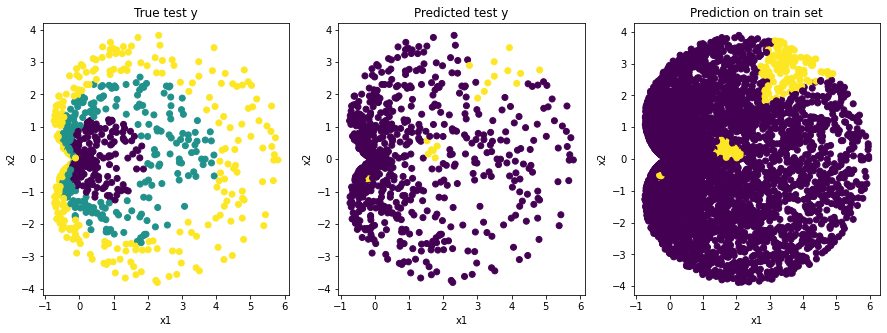

Epoch:  0 Accuracy:  33.300000000000004 %


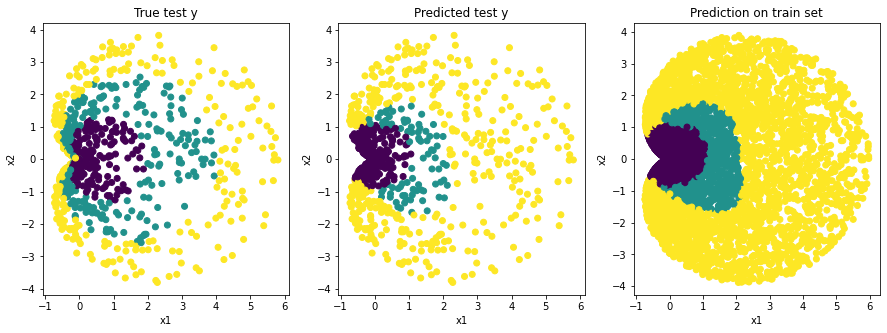

Epoch:  200 Accuracy:  54.300000000000004 %


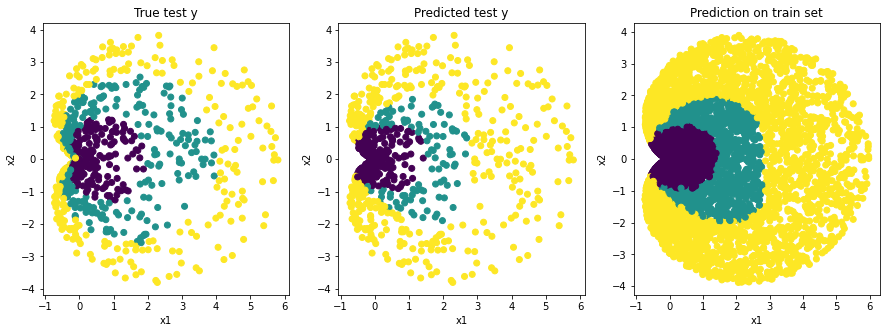

Epoch:  400 Accuracy:  60.4 %


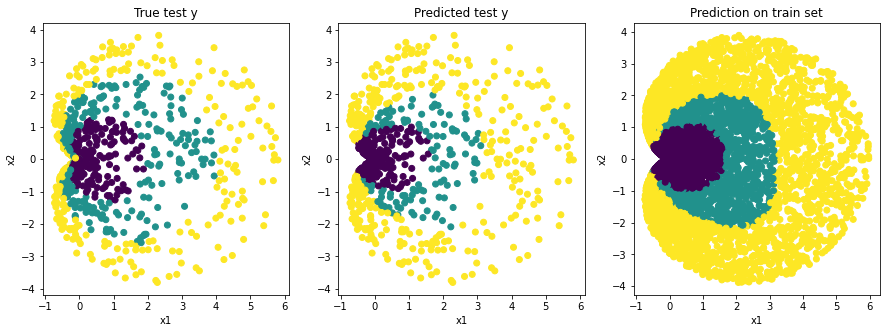

Epoch:  600 Accuracy:  63.7 %


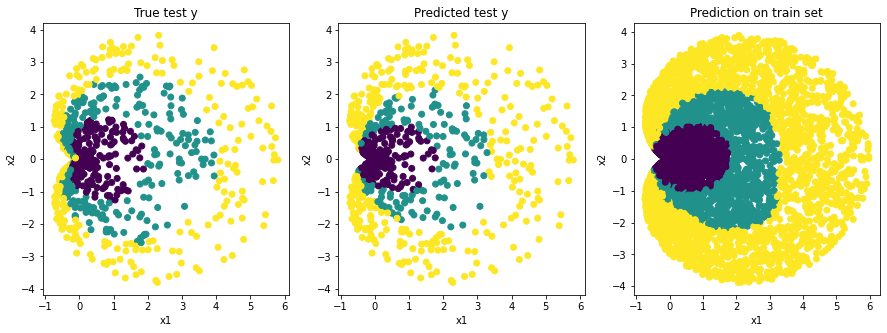

Epoch:  800 Accuracy:  67.5 %


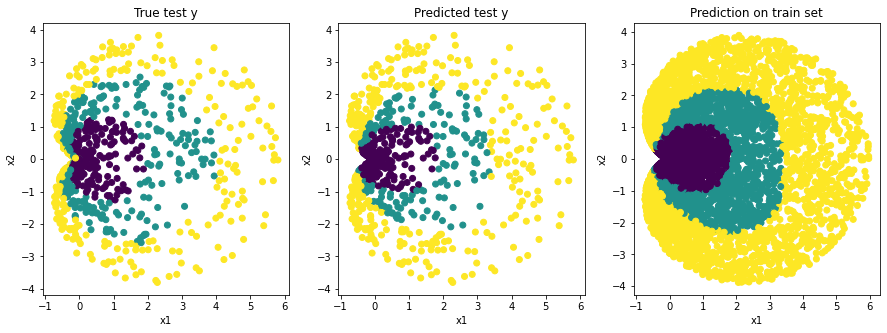

Epoch:  1000 Accuracy:  69.89999999999999 %


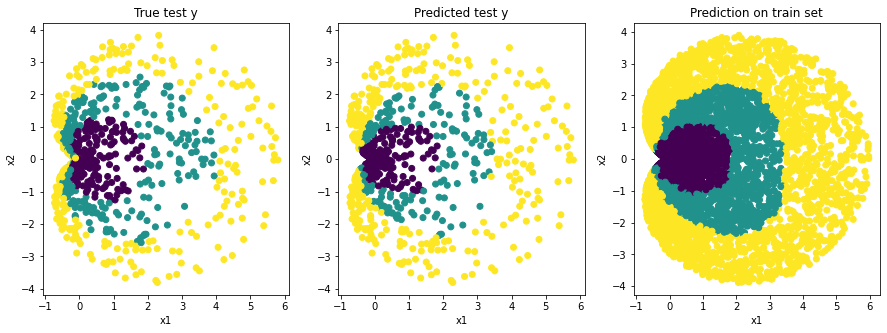

Epoch:  1200 Accuracy:  71.39999999999999 %


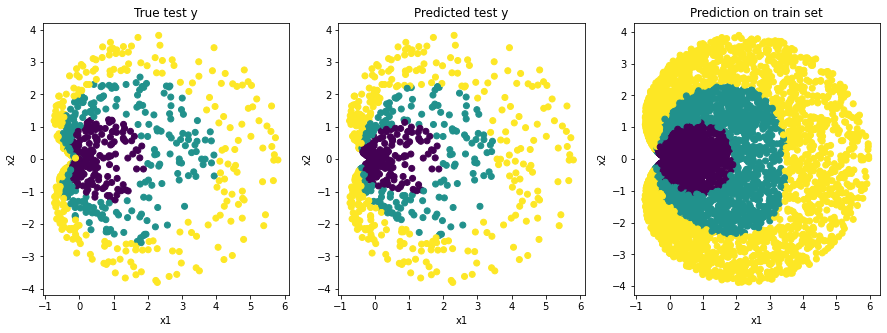

Epoch:  1400 Accuracy:  72.6 %


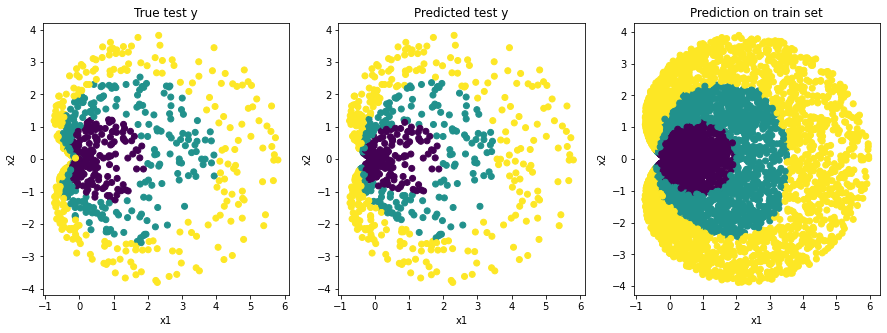

Epoch:  1600 Accuracy:  73.6 %


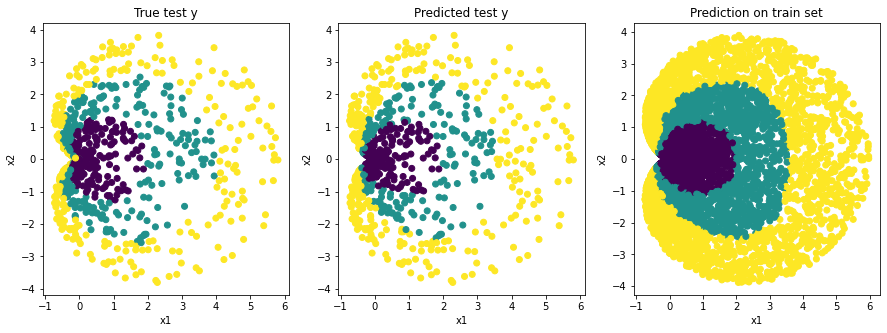

Epoch:  1800 Accuracy:  74.1 %


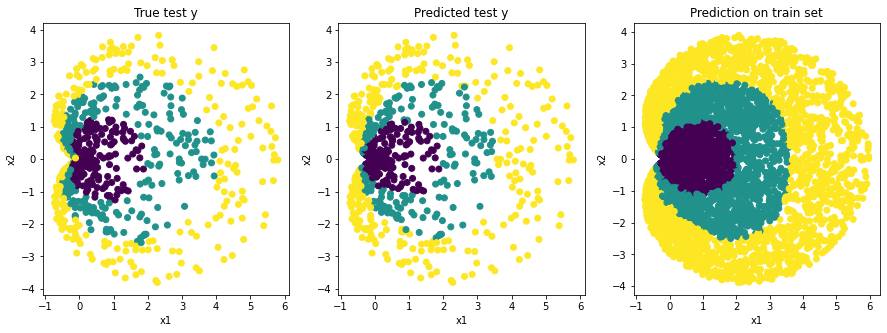

Epoch:  2000 Accuracy:  74.6 %


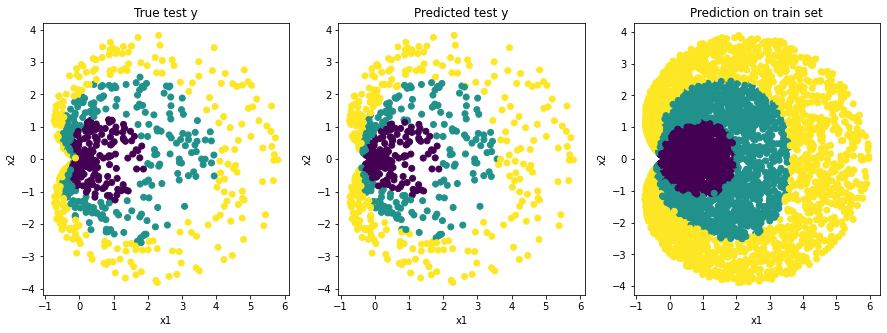

Epoch:  2200 Accuracy:  75.6 %


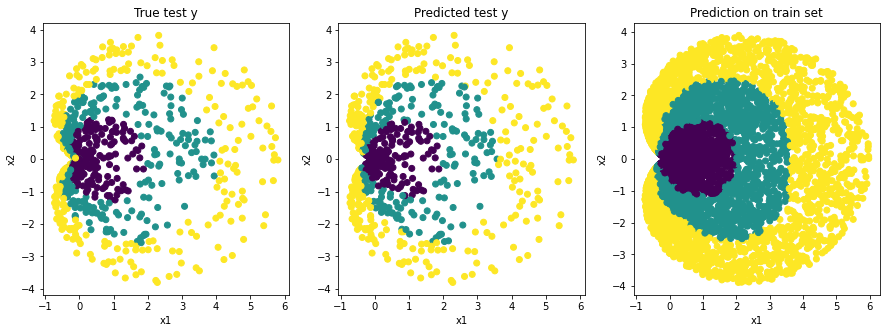

Epoch:  2400 Accuracy:  76.2 %


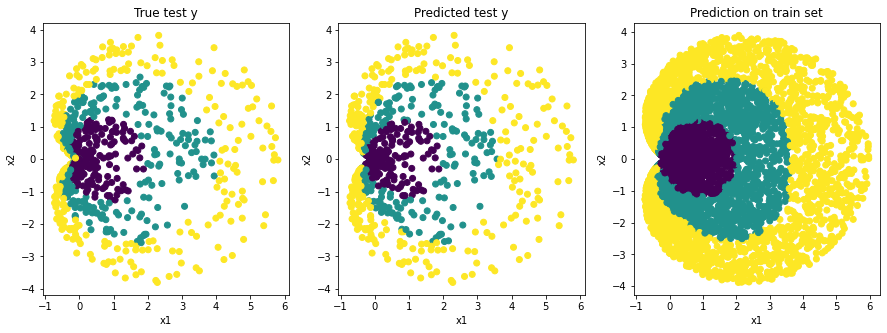

Epoch:  2600 Accuracy:  76.8 %


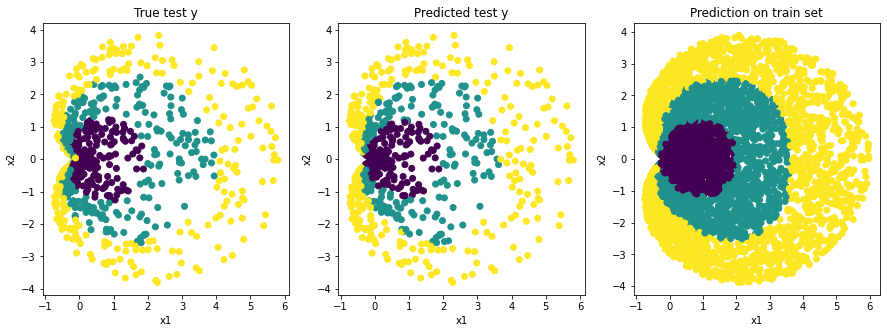

Epoch:  2800 Accuracy:  77.2 %


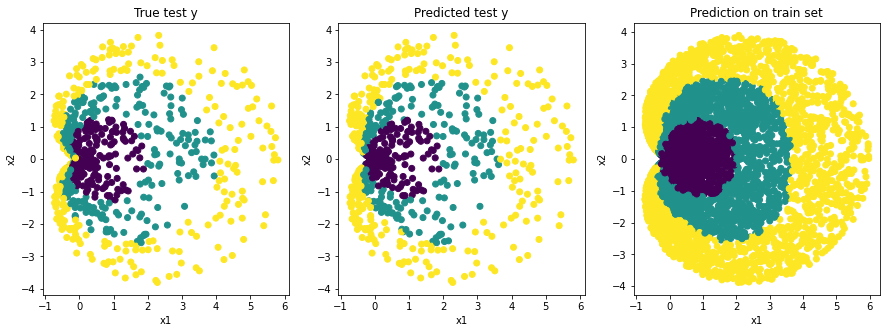

Epoch:  3000 Accuracy:  77.5 %


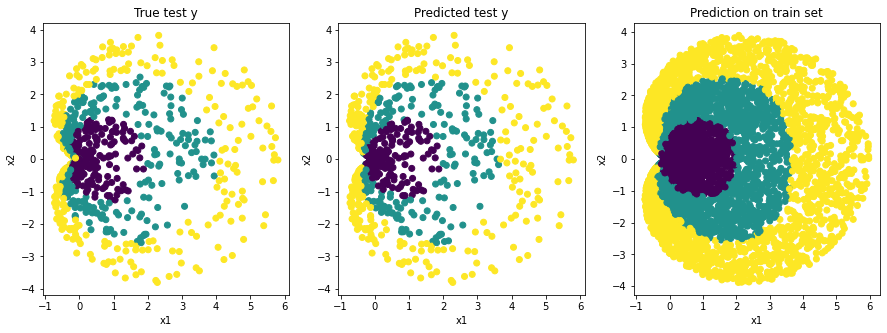

Epoch:  3200 Accuracy:  77.8 %


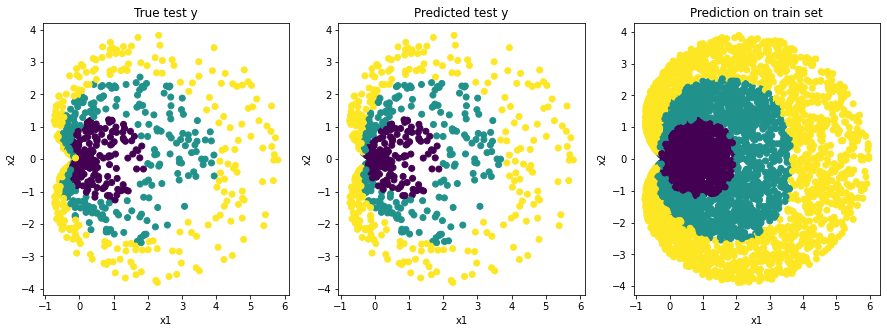

Epoch:  3400 Accuracy:  78.0 %


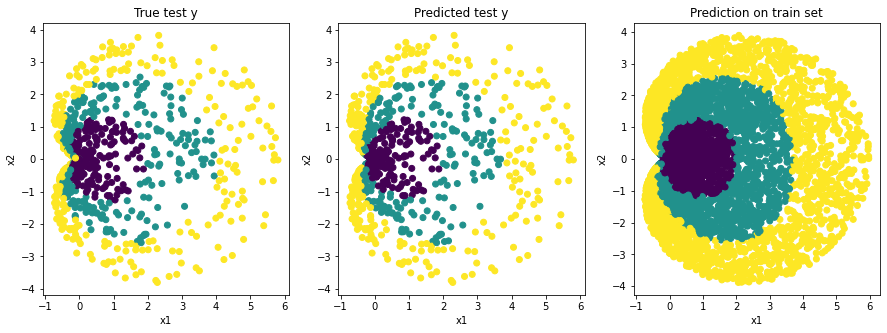

Epoch:  3600 Accuracy:  78.10000000000001 %


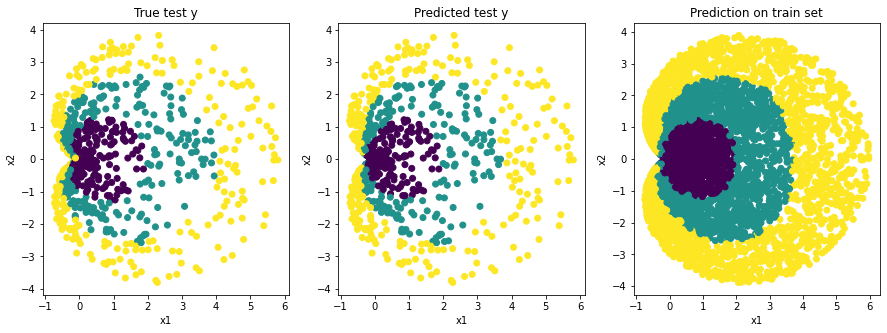

Epoch:  3800 Accuracy:  78.2 %


In [5]:
import torch.optim as optim
from sklearn.metrics import accuracy_score
#모델 확인할때 사용하는 코드
'''
model = LinearModel()
print(model.linear.weight)
print(model.linear.bias)
'''

model = MLPModel() #Model 생성
print('{} parameters'.format(sum(p.numel() for p in model.parameters() if p.requires_grad)))
#복잡해보이지만 간단히 모델 내에 학습이 진행될 파라미터 수를 카운팅하는 코드

#Optimizer
lr = 0.005  #Learning Rate
optimizer = optim.SGD(model.parameters(), lr=lr)  #Optimizer 생성

#매 학습 단계에서의 epoch값,loss 값을 저장할 리스트
list_epoch = [] 
list_train_loss = []
list_val_loss = []
list_acc = []
list_acc_epoch = []


epoch = 4000  #학습 횟수(epoch)
for i in range(epoch):
    
#train
#모델은 매 Iteration 때마다 Train Set에 의해 학습, 동시에 Validation Set을 넣고 Loss를 비교
    model.train()  #model을 train으로 세팅->향후 모델을 평가할 때는 eval()로 변경
    optimizer.zero_grad()  #optimizer에 남아있을 수도 있는 잔여 gradient 0으로 다 초기화
    
    input_x = torch.Tensor(train_X)
    true_y = torch.Tensor(train_y).long()
    pred_y = model(input_x)
    #print(input_x.shape, true_y.shape, pred_y.shape) # 각 인풋과 아웃풋의 차원 체크하는 print문
    
    loss = cls_loss(pred_y.squeeze(), true_y)
    loss.backward()  #backward()로 gradient 구하기(사용한 각 파라미터에 대한 loss의 편미분을 계산)
    optimizer.step()  #step()로 gradient 바탕의 파라미터 업데이트 진행 
    list_epoch.append(i)
    list_train_loss.append(loss.detach().numpy())
    
#Valid
    model.eval()
    optimizer.zero_grad()
    input_x = torch.Tensor(val_X)
    true_y = torch.Tensor(val_y).long()
    pred_y = model(input_x)   
    loss = cls_loss(pred_y.squeeze(), true_y)
    list_val_loss.append(loss.detach().numpy())
    

#Evaluate
    if i % 200 == 0: # 200회의 학습마다 실제 데이터 분포와 모델이 예측한 분포를 그려봅니다.
        
#MAE 계산
        model.eval()
        optimizer.zero_grad()
        input_x = torch.Tensor(test_X)
        true_y = torch.Tensor(test_y)
        pred_y = model(input_x).detach().max(dim=1)[1].numpy() 
        acc = accuracy_score(true_y, pred_y) #sklearn함수들은 true_y 가 먼저, pred_y가 나중에 인자로 들어감.
        list_acc.append(acc)
        list_acc_epoch.append(i)
        fig = plt.figure(figsize=(15,5))
        
#True Y Scatter
        ax1 = fig.add_subplot(1, 3, 1)
        ax1.scatter(test_X[:, 0], test_X[:, 1], c=test_y)
        ax1.set_xlabel('x1')
        ax1.set_ylabel('x2')
        ax1.set_title('True test y')
        
#Predicted Y Scatter
        ax2 = fig.add_subplot(1, 3, 2)
        ax2.scatter(test_X[:, 0], test_X[:, 1], c=pred_y)
        ax2.set_xlabel('x1')
        ax2.set_ylabel('x2')
        ax2.set_title('Predicted test y')
        
#Visualizaing with High Resolution
        input_x = torch.Tensor(train_X)
        pred_y = model(input_x).detach().max(dim=1)[1].numpy() 
        
        ax3 = fig.add_subplot(1, 3, 3)
        ax3.scatter(train_X[:, 0], train_X[:, 1], c=pred_y)
        ax3.set_xlabel('x1')
        ax3.set_ylabel('x2')
        ax3.set_title('Prediction on train set')

        plt.show()
        print('Epoch: ', i,  'Accuracy: ', acc*100, '%')

위 그래프 결과 정확도 78.2 확인

### 5. Report Experiment  
학습 과정에서 기록했던 train_loss와 val_loss를 그려기

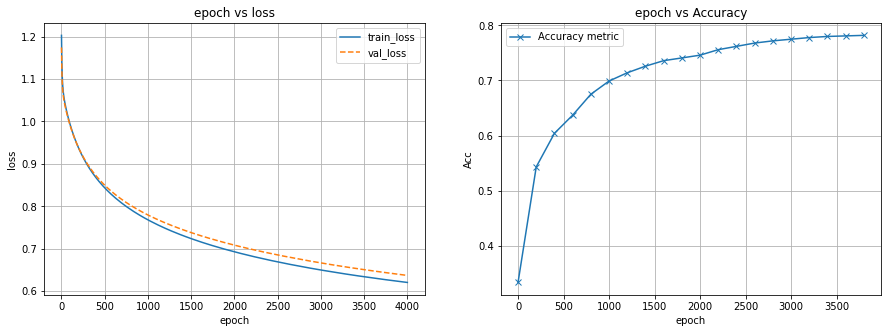

In [6]:
fig = plt.figure(figsize=(15,5))

#Loss Fluctuation(loss 변동사항 그리기)
ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(list_epoch, list_train_loss, label='train_loss')
ax1.plot(list_epoch, list_val_loss, '--', label='val_loss')
ax1.set_xlabel('epoch')
ax1.set_ylabel('loss')
ax1.grid()
ax1.legend()
ax1.set_title('epoch vs loss')

#Metric Fluctuation(MAE 변동사항 그리기)
ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(list_acc_epoch, list_acc, marker='x', label='Accuracy metric')
ax2.set_xlabel('epoch')
ax2.set_ylabel('Acc')
ax2.grid()
ax2.legend()
ax2.set_title('epoch vs Accuracy')

plt.show()

# **linear model로 본 실습을 진행한다면?**

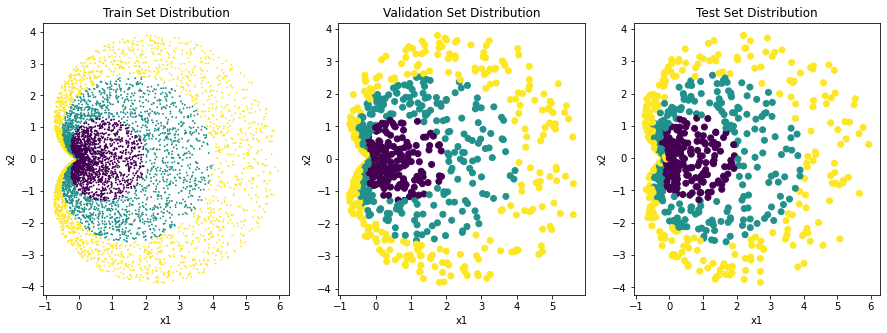

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

#데이터셋 만들기 
r = np.random.rand(10000)*3  #r=10000개
theta = np.random.rand(10000)*2*np.pi  #세타역시=10000개  
y = r.astype(int)  #y를 다 정수형으로 변형(소수점제거),클래스가 정수형(0,1,2)로 나뉘기 위함
r = r * (np.cos(theta) + 1)
x1 = r * np.cos(theta)
x2 = r * np.sin(theta)
X = np.array([x1, x2]).T

#데이터셋을 Train, Validation, Test으로 split
train_X, train_y = X[:8000, :], y[:8000]  #8000개
val_X, val_y = X[8000:9000, :], y[8000:9000]  #1000개
test_X, test_y = X[9000:, :], y[9000:]  #1000개

#Visualize
fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(1, 3, 1)
ax1.scatter(train_X[:, 0], train_X[:, 1], c=train_y, s=0.7)  #c=train_y, 각 클래스별로 다른색을 가지도록,s는 점의사이즈
ax1.set_xlabel('x1')
ax1.set_ylabel('x2')
ax1.set_title('Train Set Distribution')

ax2 = fig.add_subplot(1, 3, 2)
ax2.scatter(val_X[:, 0], val_X[:, 1], c=val_y)
ax2.set_xlabel('x1')
ax2.set_ylabel('x2')
ax2.set_title('Validation Set Distribution')

ax3 = fig.add_subplot(1, 3, 3)
ax3.scatter(test_X[:, 0], test_X[:, 1], c=test_y)
ax3.set_xlabel('x1')
ax3.set_ylabel('x2')
ax3.set_title('Test Set Distribution')
plt.show()

In [3]:
import torch
import torch.nn as nn

#Logistic Regression Model을 파이토치로 구현할 때
#Regression과 똑같이 `nn.Linear`모듈, non-linear activation function 사용하면됨

#중요 : Model 내에서 Softmax를 사용할 필요가 없음->CrossEntropyLoss 함수에 들어가있음
class LinearModel(nn.Module):  #linear 모델
    def __init__(self): 
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(in_features=2, out_features=3, bias=True)  #x차원 2 y차원3   
    
    def forward(self, x):  #인스턴스(샘플) x가 인풋으로 들어왔을 때 모델이 예측하는 y값을 리턴
        x = self.linear(x)
        return x
    
class MLPModel(nn.Module):  #MLP 모델
    def __init__(self): 
        super(MLPModel, self).__init__()
        self.linear1 = nn.Linear(in_features=2, out_features=200)
        self.linear2 = nn.Linear(in_features=200, out_features=3)
        self.relu = nn.ReLU()
    
    def forward(self, x):  #인스턴스(샘플) x가 인풋으로 들어왔을 때 모델이 예측하는 y값을 리턴
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)
        return x

In [4]:
#Multi-Label Problem 에서의 Loss Function 작성
#실습은 Classification Problem 이므로 `CrossEntropyLoss()` 사용
cls_loss = nn.CrossEntropyLoss()

"""# Cross Entropy를 테스트해봅시다
test_pred_y = torch.Tensor([[2,0.1],[0,1]])
test_true_y1 = torch.Tensor([1,0]).long()
test_true_y2 = torch.Tensor([0,1]).long()

print(cls_loss(test_pred_y, test_true_y1))
print(cls_loss(test_pred_y, test_true_y2))
"""

'# Cross Entropy를 테스트해봅시다\ntest_pred_y = torch.Tensor([[2,0.1],[0,1]])\ntest_true_y1 = torch.Tensor([1,0]).long()\ntest_true_y2 = torch.Tensor([0,1]).long()\n\nprint(cls_loss(test_pred_y, test_true_y1))\nprint(cls_loss(test_pred_y, test_true_y2))\n'

9 parameters


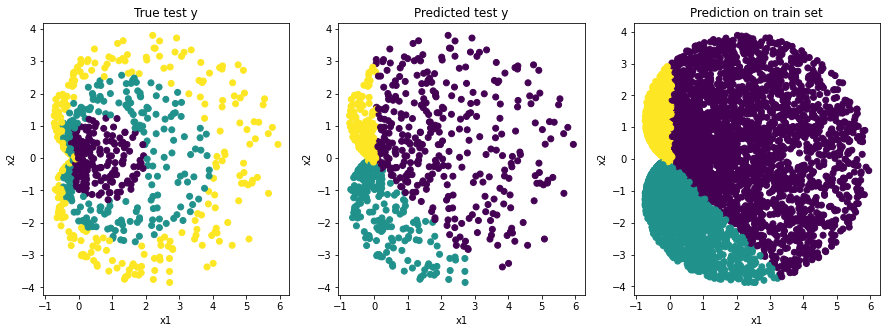

Epoch:  0 Accuracy:  33.2 %


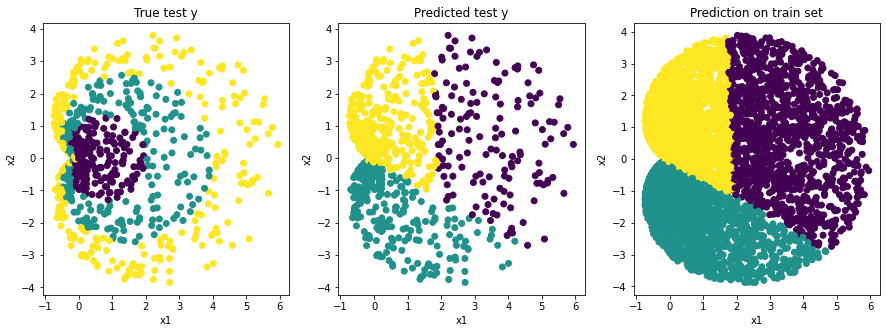

Epoch:  200 Accuracy:  25.1 %


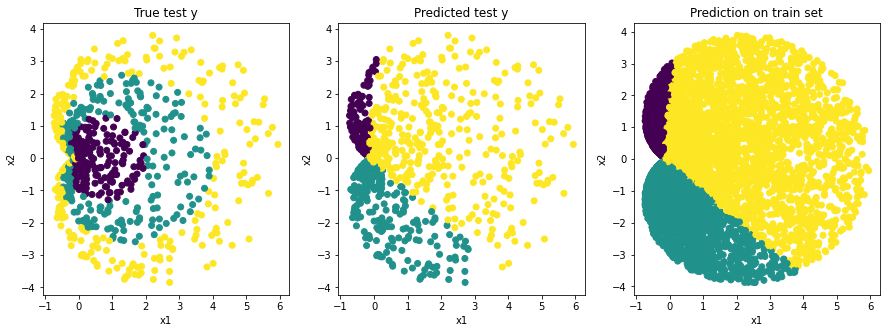

Epoch:  400 Accuracy:  27.1 %


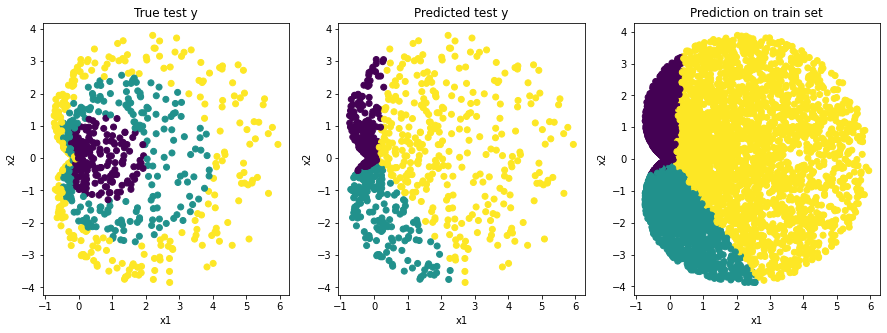

Epoch:  600 Accuracy:  39.1 %


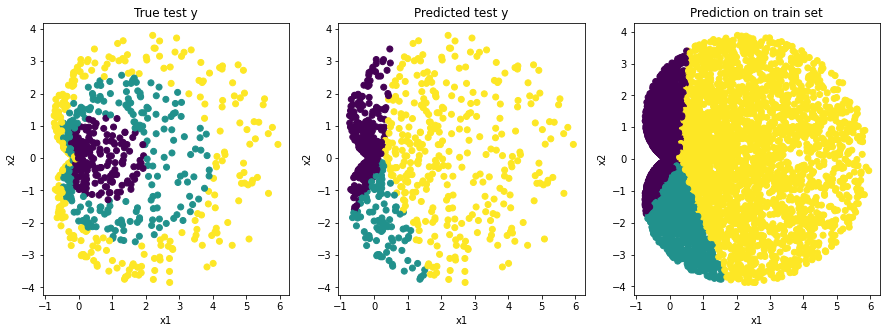

Epoch:  800 Accuracy:  39.7 %


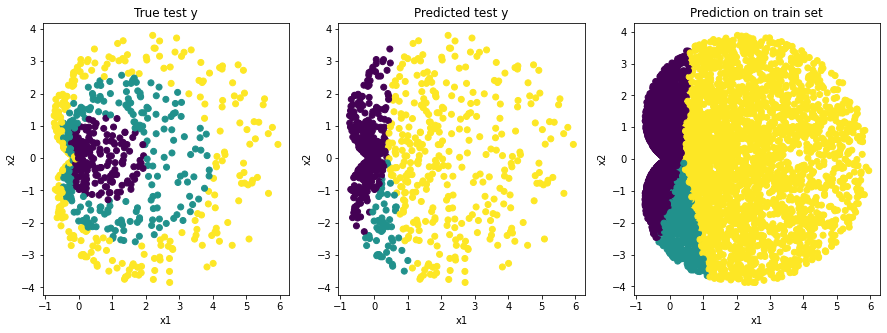

Epoch:  1000 Accuracy:  41.0 %


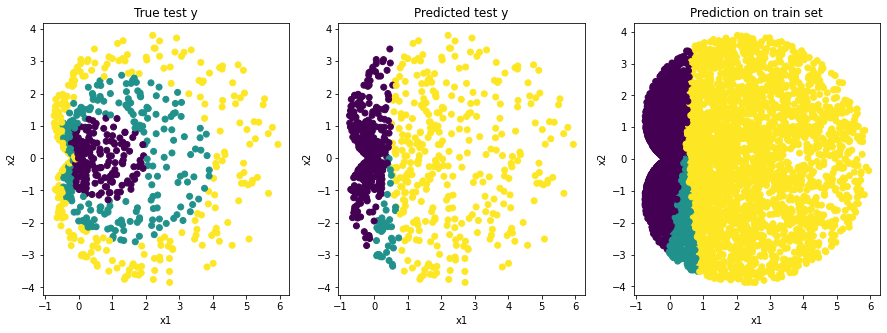

Epoch:  1200 Accuracy:  41.9 %


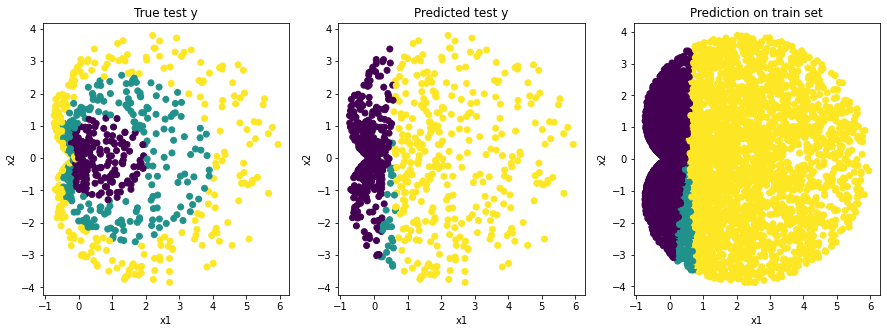

Epoch:  1400 Accuracy:  41.8 %


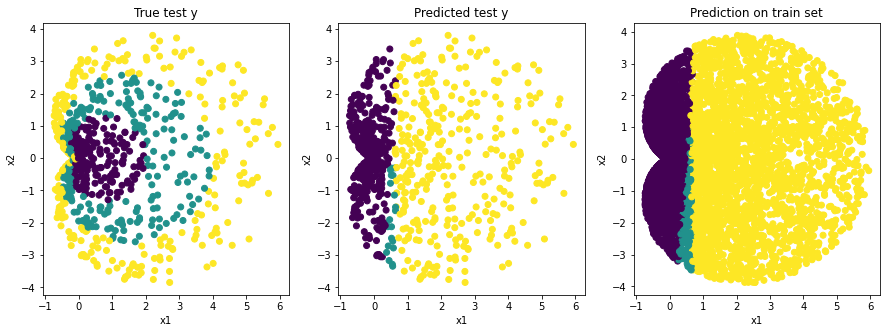

Epoch:  1600 Accuracy:  41.6 %


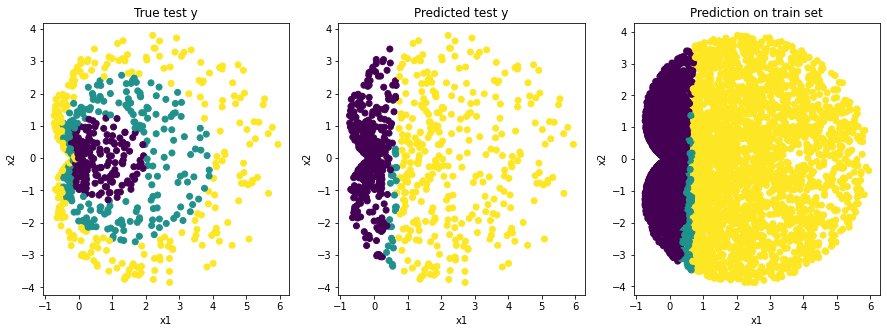

Epoch:  1800 Accuracy:  41.699999999999996 %


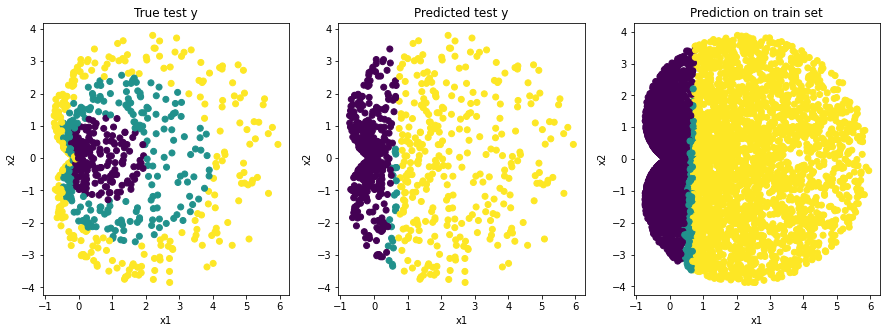

Epoch:  2000 Accuracy:  41.8 %


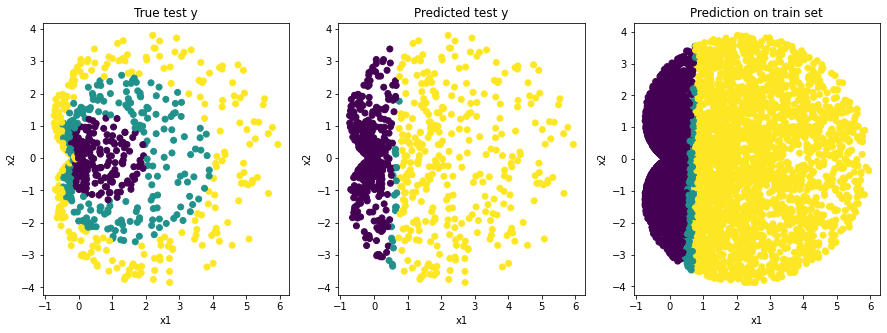

Epoch:  2200 Accuracy:  41.9 %


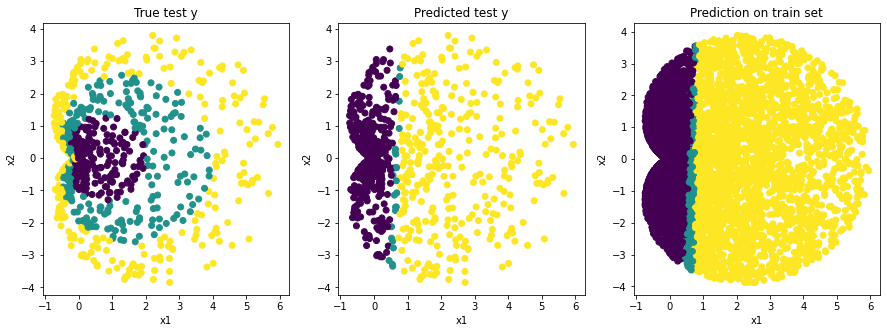

Epoch:  2400 Accuracy:  41.699999999999996 %


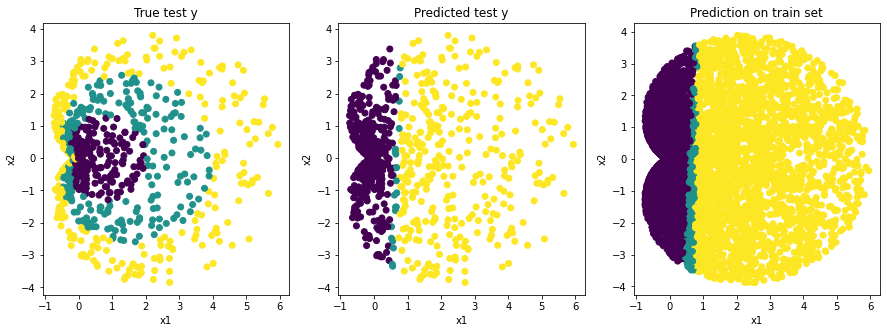

Epoch:  2600 Accuracy:  41.8 %


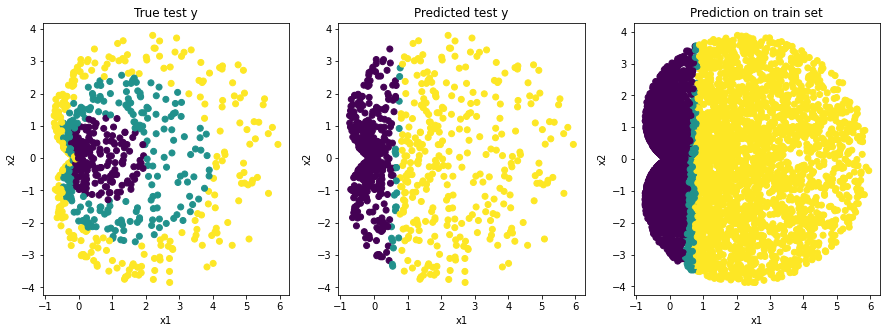

Epoch:  2800 Accuracy:  41.699999999999996 %


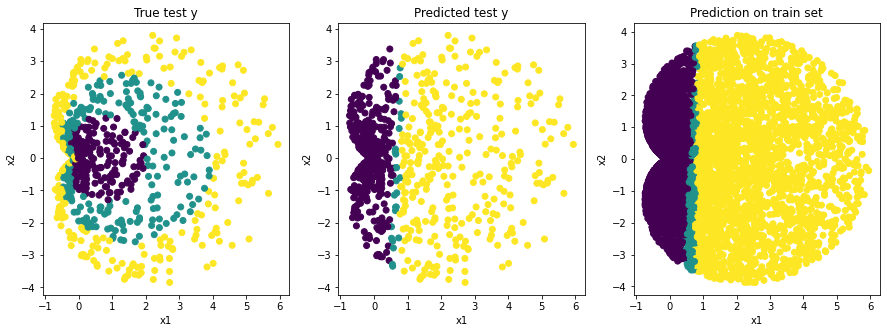

Epoch:  3000 Accuracy:  41.8 %


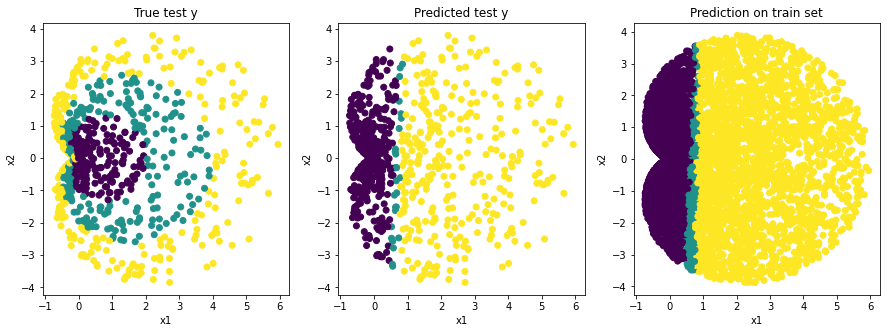

Epoch:  3200 Accuracy:  41.699999999999996 %


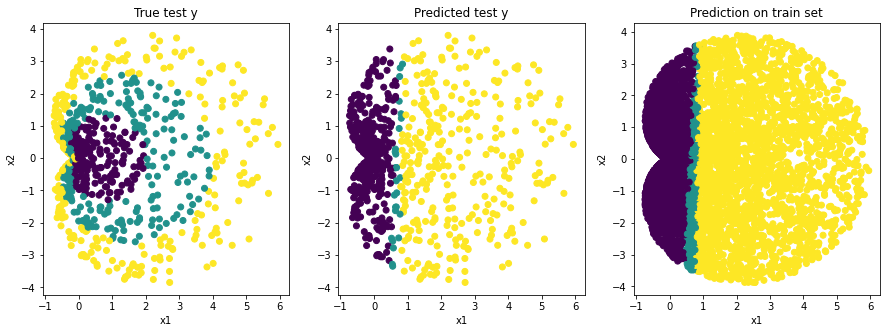

Epoch:  3400 Accuracy:  41.699999999999996 %


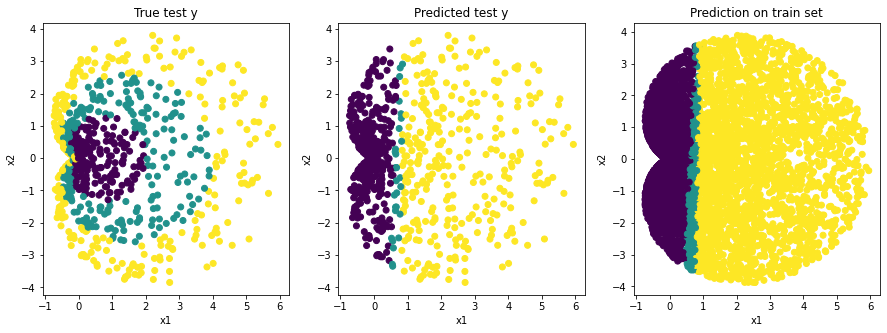

Epoch:  3600 Accuracy:  41.699999999999996 %


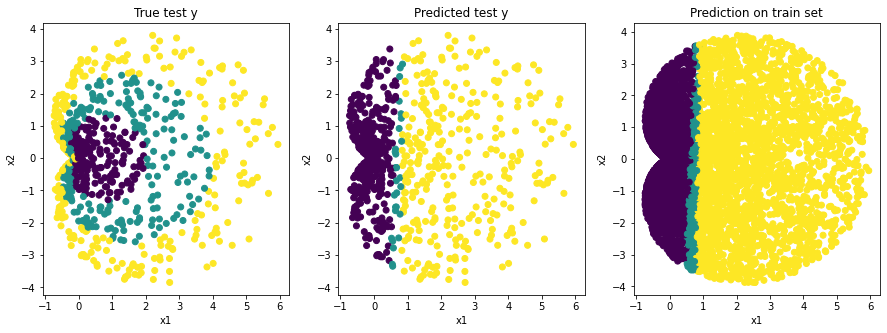

Epoch:  3800 Accuracy:  41.699999999999996 %


In [5]:
import torch.optim as optim
from sklearn.metrics import accuracy_score
#모델 확인할때 사용하는 코드

model = LinearModel()  #Model 생성
'''
print(model.linear.weight)
print(model.linear.bias)
'''

#model = MLPModel() 
print('{} parameters'.format(sum(p.numel() for p in model.parameters() if p.requires_grad)))
#복잡해보이지만 간단히 모델 내에 학습이 진행될 파라미터 수를 카운팅하는 코드

#Optimizer
lr = 0.005  #Learning Rate
optimizer = optim.SGD(model.parameters(), lr=lr)  #Optimizer 생성

#매 학습 단계에서의 epoch값,loss 값을 저장할 리스트
list_epoch = [] 
list_train_loss = []
list_val_loss = []
list_acc = []
list_acc_epoch = []


epoch = 4000  #학습 횟수(epoch)
for i in range(epoch):
    
#train
#모델은 매 Iteration 때마다 Train Set에 의해 학습, 동시에 Validation Set을 넣고 Loss를 비교
    model.train()  #model을 train으로 세팅->향후 모델을 평가할 때는 eval()로 변경
    optimizer.zero_grad()  #optimizer에 남아있을 수도 있는 잔여 gradient 0으로 다 초기화
    
    input_x = torch.Tensor(train_X)
    true_y = torch.Tensor(train_y).long()
    pred_y = model(input_x)
    #print(input_x.shape, true_y.shape, pred_y.shape) # 각 인풋과 아웃풋의 차원 체크하는 print문
    
    loss = cls_loss(pred_y.squeeze(), true_y)
    loss.backward()  #backward()로 gradient 구하기(사용한 각 파라미터에 대한 loss의 편미분을 계산)
    optimizer.step()  #step()로 gradient 바탕의 파라미터 업데이트 진행 
    list_epoch.append(i)
    list_train_loss.append(loss.detach().numpy())
    
#Valid
    model.eval()
    optimizer.zero_grad()
    input_x = torch.Tensor(val_X)
    true_y = torch.Tensor(val_y).long()
    pred_y = model(input_x)   
    loss = cls_loss(pred_y.squeeze(), true_y)
    list_val_loss.append(loss.detach().numpy())
    

#Evaluate
    if i % 200 == 0: # 200회의 학습마다 실제 데이터 분포와 모델이 예측한 분포를 그려봅니다.
        
#MAE 계산
        model.eval()
        optimizer.zero_grad()
        input_x = torch.Tensor(test_X)
        true_y = torch.Tensor(test_y)
        pred_y = model(input_x).detach().max(dim=1)[1].numpy() 
        acc = accuracy_score(true_y, pred_y) #sklearn함수들은 true_y 가 먼저, pred_y가 나중에 인자로 들어감.
        list_acc.append(acc)
        list_acc_epoch.append(i)
        fig = plt.figure(figsize=(15,5))
        
#True Y Scatter
        ax1 = fig.add_subplot(1, 3, 1)
        ax1.scatter(test_X[:, 0], test_X[:, 1], c=test_y)
        ax1.set_xlabel('x1')
        ax1.set_ylabel('x2')
        ax1.set_title('True test y')
        
#Predicted Y Scatter
        ax2 = fig.add_subplot(1, 3, 2)
        ax2.scatter(test_X[:, 0], test_X[:, 1], c=pred_y)
        ax2.set_xlabel('x1')
        ax2.set_ylabel('x2')
        ax2.set_title('Predicted test y')
        
#Visualizaing with High Resolution
        input_x = torch.Tensor(train_X)
        pred_y = model(input_x).detach().max(dim=1)[1].numpy() 
        
        ax3 = fig.add_subplot(1, 3, 3)
        ax3.scatter(train_X[:, 0], train_X[:, 1], c=pred_y)
        ax3.set_xlabel('x1')
        ax3.set_ylabel('x2')
        ax3.set_title('Prediction on train set')

        plt.show()
        print('Epoch: ', i,  'Accuracy: ', acc*100, '%')

실험결과:precited test y(가운데)decision boundary가 다 직선으로 되어있다. 값이 0이 되는 구간들을 모아놓고 보면 직선을 이룬다. 이들은 직선으로밖에 구분이 안간다.. 결국 제대로 분류가 안되는 현상을 확인할 수 있다.

 **non linear한 decision boundary를 logistic classification으로 만들수 없다는 것을 확인할 수 있다.**

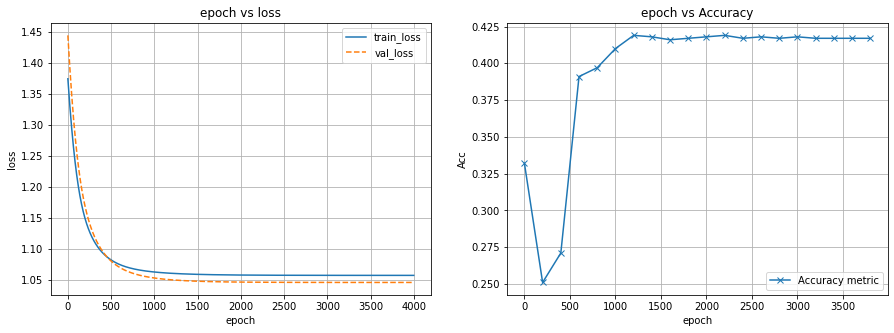

In [6]:
fig = plt.figure(figsize=(15,5))

#Loss Fluctuation(loss 변동사항 그리기)
ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(list_epoch, list_train_loss, label='train_loss')
ax1.plot(list_epoch, list_val_loss, '--', label='val_loss')
ax1.set_xlabel('epoch')
ax1.set_ylabel('loss')
ax1.grid()
ax1.legend()
ax1.set_title('epoch vs loss')

#Metric Fluctuation(MAE 변동사항 그리기)
ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(list_acc_epoch, list_acc, marker='x', label='Accuracy metric')
ax2.set_xlabel('epoch')
ax2.set_ylabel('Acc')
ax2.grid()
ax2.legend()
ax2.set_title('epoch vs Accuracy')

plt.show()

[왼쪽]
train_loss 가 val_loss보다 높아진다. overfitting
[오른쪽]
accuracy가 매우 높지않다. 적절하지않은 모델을 사용해서 그렇다.